Time series modelling for the prediction of stocks prices is a challenging task.  Political events, market expectations and economic factors are just a few known factors that can impact financial market behaviour. The financial market is a complex, noisy, evolutionary and chaotic field of study that attracts many enthusiasts and researches — the first, usually driven by the economic benefit of it, the latter, inspired by the challenge of handling such complex data.

This project aims to predict Facebook (FB) next day stock price direction with machine learning algorithms. Technical indicators and global market
indexes are used, and their influence on the forecast accuracy is analysed. The machine learning models applied to stock movement forecasting are SVM, random forest and logistic regression. An analysis of using an Ensemble Model is also performed. Final results are compared with existing literature for Facebook stock.

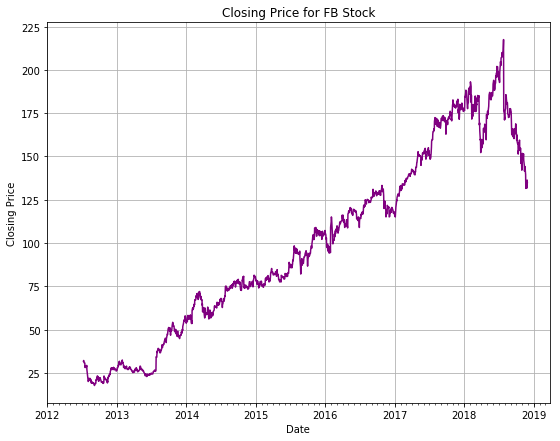

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from statistics import mode 
from sklearn.ensemble import VotingClassifier
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def data_load(filename,date):
    return pd.read_csv(filename,parse_dates = [date])

FB = data_load('../input/FB.csv','Date')
FB_feat = FB.iloc[:, 1:-1].values
FB_target = FB.iloc[:, -1].values
#####################################################
#Plot the closing price across the years
fig, ax = plt.subplots(figsize=(9, 7))
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
# Add the x-axis and the y-axis to the plot
ax.plot(FB['Date'].values,
        FB['Close'], data = FB['Close'].values,
        color='purple')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Closing Price",
       title="Closing Price for FB Stock")

# round to nearest years.
datemin = np.datetime64(FB['Date'][0], 'Y')
datemax = np.datetime64(FB['Date'].iloc[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

From mid 2012 to early 2018 the tech company showed a consistent uptrend market. However, the closing price has started to consistently drop after this period, presenting a downward trend until the last day of data collection (28/11/2018).

1. Dataset

Daily values were retrieved (volume, open, close, low and high prices) from Yahoo! Finance website. For Facebook (FB), July 2012 was the earliest data available. The date range is July 2012 to November 2018.

The closing price of current day C(t) and closing price from the previous day C(t-1) are compared to build the initial dataset. The objective is to define if the price trend is going up or down by analysing these two values. For each instance, a comparison was made and recorded. If the price is going up, C(t) > C(t-1), class “1” is assigned. Class “0” is assigned for the opposite case. With these initial features, the model accuracy does not surpass 50%.

Further input features were added next. Technical indicators are used by researches and financial market analysts to support stock market trend forecasting. There are several technical indicators available in the literature. The work from [4], [7] and [11] was used as a reference. Common indicators between these three papers were selected and calculated for
Facebook stock.

Deterministic data is used as features in [7] and the same concept is applied to this dataset. Technical indicators provide a suggestion of the stock price movement. For each technical indicator, its daily value is analysed, and a class is assigned for that day. Class “1” is given if the indicator suggests upper trend, class “0” for a downtrend. In other words, financial market analysis is performed at a simplistic level, in the attempt to translate what the continuous value means.

For a given country or region, the stock market index characterises the performance of its financial market and the overall local economy.  For this
reason, the same day performance of these markets could contribute to the machine learning model predictions. Similar to [8], six global indexes were added as features, with their closing direction as up or down, class “1” or “0”, respectively. Data for these indexes (Nikkei, Hang Seng, All Ordinaries, Euronext 100, SSE and DAX) were also retrieved from Yahoo! Finance.

In [ ]:
FB.head(10)

In [ ]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d" %(size[0],size[1], sum_duplicates, sum_null))
basic_EDA(FB)

As the dataset was built manually the result above was expected. No null values or duplicated entries. Next, we analyse the class imbalance:

In [ ]:
def bar_plot(df, target):
    unique, counts = np.unique(target, return_counts = True)
    label = np.zeros(len(unique))
    for i in range(len(unique)):
        label[i] = (counts[i]/df.shape[0])*100
        plt.bar(unique,counts, color = ['burlywood', 'green'], edgecolor='black')
        plt.text(x = unique[i]-0.15, y = counts[i]+0.01*df.shape[0], s = str("%.2f%%" % label[i]), size = 15)
    plt.ylim(0, df.shape[0])
    plt.xticks(unique)
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.show()
    return unique, counts

##Visualise Class Imbalance - Training Set
num_classes, feat_per_class = bar_plot(FB, FB["Closing_Direction"])

There is a similar distribution between the number of times the price went up (class 1) or down (class 0), as expected for this kind of financial data. Next, the features correlation is analysed:

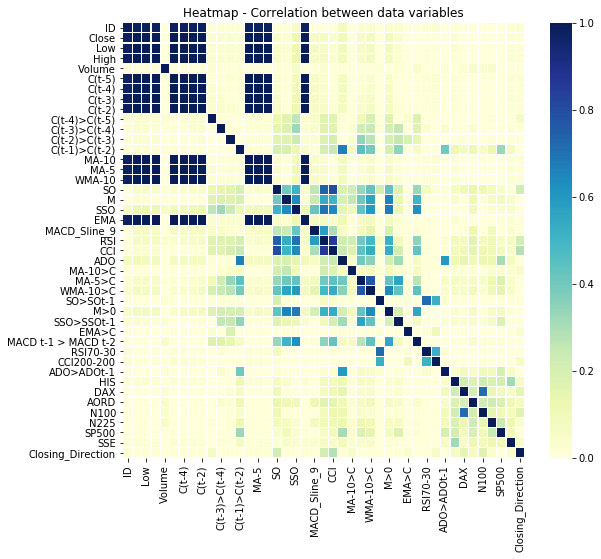

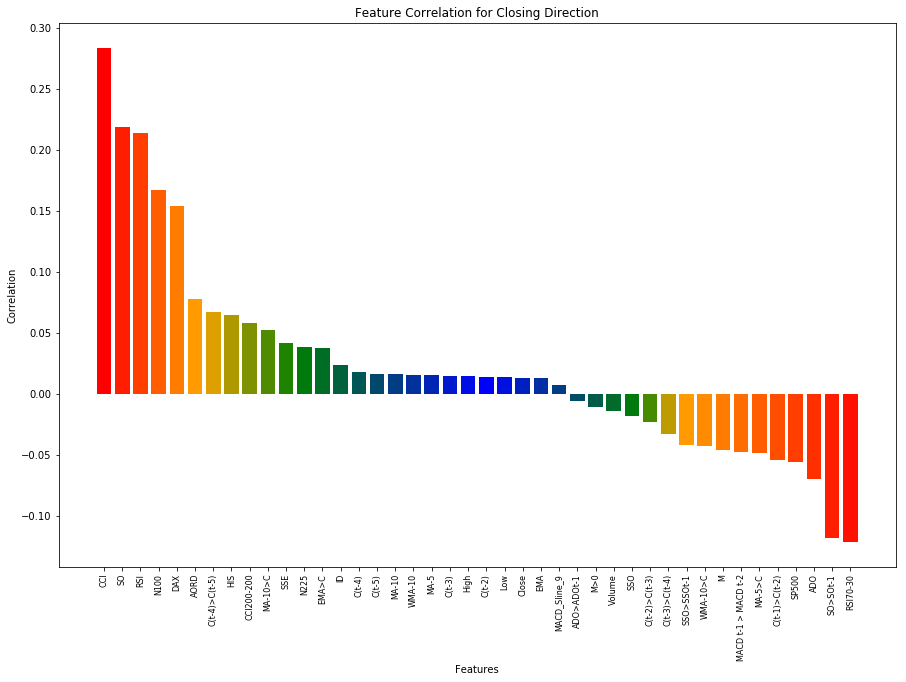

In [26]:
def feat_corr_analysis(corrmat):
    f, ax = plt.subplots(figsize =(9, 8)) 
    #1 Heatmap
    sns.heatmap(corrmat, vmin=0, vmax=1, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
    plt.title("Heatmap - Correlation between data variables")
    
    #2 Correlation Values and Features
    correlations = corrmat.abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    Clos_dir_corr = corrmat['Closing_Direction']
    Clos_dir_corr = FB_corr['Closing_Direction'].drop(['Closing_Direction'], axis =0)
    Clos_dir_corr = Clos_dir_corr.sort_values(ascending = False)  
    
    #Plot with different colours for better visualisation
    clist = [(0, "red"), (0.125, "orange"), (0.25, "green"), (0.5, "blue"), 
             (0.7, "green"), (0.75, "orange"), (1, "red")]
    rvb = mcolors.LinearSegmentedColormap.from_list("", clist)    
    N = Clos_dir_corr.shape[0]
    Col_range = np.arange(N).astype(float)
    #Create Bar Plot
    plt.figure(figsize=(15,10))
    plt.bar(Clos_dir_corr.index, Clos_dir_corr[:],color=rvb(Col_range/N))
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.xticks(fontsize=8,rotation=90)
    plt.title('Feature Correlation for Closing Direction')
    plt.show()
    return 

FB_corr = FB.corr()
feat_corr_analysis(FB_corr)

From the correlation analysis is interesting to see how the additional features have a higher correlation with the closing price. Preliminary tests shown that these additional features significantly helped the model to predict the stock behaviour. This analysis can help to select other technical indicators or market indexes in the future.  

Models

The approach taken to train and test the machine learning models is referred to as sliding window or walk-forward. This method consists of dividing the dataset into several time frames. The sliding window routine creates training and test set of equal size for each window; the sets go forward in time according to the step size selected. By applying this method, the model is based on more recent data.

The final model and parameters shown below are the ones that provided the best accuracy considering the average accuracy from all windows. For this project, is decided to compare the performance of SVM, Logistic Regression and Random Forest. 

In [27]:
##########################################
def RFELogisticRegression(x_train,y_train,x_test,y_test):
    reg_C = 50
    classifier = LogisticRegression(solver = 'liblinear', penalty = 'l1',C = reg_C,max_iter = 5000)
    classifier.fit(x_train,y_train)
    accuracy_training = 100*classifier.score(x_train,y_train)
    accuracy_testing = 100*classifier.score(x_test,y_test)
    return accuracy_testing
###########################################
def RFESVC(x_train,y_train, x_test, y_test, reg_C, gm):
    classifier = SVC(kernel= 'rbf', C= reg_C, gamma= gm)# creates the model
    classifier.fit(x_train,y_train)#fits the data
    accuracy_training = 100*classifier.score(x_train,y_train)
    accuracy_testing = 100*classifier.score(x_test,y_test)
    return accuracy_testing
############################################
def RFERandomForest(x_train,y_train,x_test,y_test):
    classifier = RandomForestClassifier(criterion= 'gini', 
                            max_depth= 2,
                            n_estimators= 10,
                            random_state= 0)
    classifier.fit(x_train,y_train)
    accuracy_training = 100*classifier.score(x_train,y_train)
    accuracy_testing = 100*classifier.score(x_test,y_test)
    return accuracy_testing
############################################
#Ensemble Model - Does not consider Random Forest due to lower accuracy    
LRC = LogisticRegression(solver = 'liblinear', penalty = 'l1',C = 50,max_iter = 5000)
SVCC = SVC(kernel= 'rbf', C= 60, gamma= 0.001,probability=True)
Ensemble_model = VotingClassifier(estimators=[('lr', LRC), ('SVC', SVCC)], voting='soft', weights=[1,1.2])
#############################################

The block below divides the dataset into 5 windows and retrieves the accuracy of each model.

In [28]:
RF_Acc = []
EM_Acc = []
SVM_Acc = []
LR_Acc = []
#Number of Windows / Size of Training Set/ Size of Test Set
n_fold = 5;train_set = 459; test_set = 113;
sc_X = RobustScaler()
FB_index= np.asarray(list(range(0, FB_feat.shape[0]+1)))
window = 0
for i in range(5):
    train_index = FB_index[(FB_index >= window) & (FB_index < window + train_set)]
    test_index = FB_index[(FB_index >train_index.max()) & (FB_index <= train_index.max()+test_set)]
    X_train, X_test = FB_feat[train_index], FB_feat[test_index]
    y_train, y_test = FB_target[train_index], FB_target[test_index]
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    #Logistic Regression
    LR = RFELogisticRegression(X_train,y_train,X_test,y_test)
    LR_Acc.append(LR)
    #SVM
    SVM = RFESVC(X_train,y_train,X_test,y_test,60,0.001)
    SVM_Acc.append(SVM)
    #Random Forest
    RF = RFERandomForest(X_train,y_train,X_test,y_test)
    RF_Acc.append(RF)
    #Ensemble Model
    Ensemble_model.fit(X_train,y_train)
    EM_Score = 100*Ensemble_model.score(X_test,y_test)
    EM_Acc.append(EM_Score)
    #Step forward
    window += 259

#Mean Final Accuracy across all Windows
SVM_Final_Acc = np.mean(SVM_Acc)
LR_Final_Acc = np.mean(LR_Acc)
RF_Final_Acc = np.mean(RF_Acc)
EM_Final_Acc = np.mean(EM_Acc)

In [29]:
#Comparison between individual models and ensemble
print("SVM Model: %.2f%%"%(SVM_Final_Acc))
print("LR Model: %.2f%%"%(LR_Final_Acc))
print("RF Model: %.2f%%"%(RF_Final_Acc))
print("Ensemble Model: %.2f%%"%(EM_Final_Acc))

SVM Model: 78.05%
LR Model: 76.99%
RF Model: 66.37%
Ensemble Model: 77.35%


SVM has shown to be the most accurate model, followed by the ensemble containing LR and SVM. The result was obtained by performing the mean across all windows. The figure below allows the analysis of each model across the individual windows.

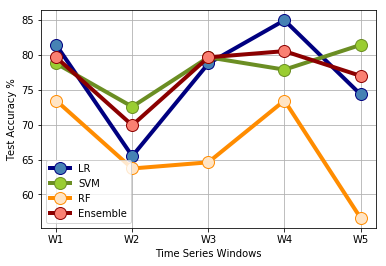

In [30]:
#Analysis of each Window Accuracy
Results = ["W1","W2","W3","W4","W5"]
title = 'Accuracy Across Windows'
plt.plot( Results, LR_Acc, marker='o', markerfacecolor='steelblue', markersize=12, color='navy', linewidth=4, label = 'LR')
plt.plot( Results, SVM_Acc, marker='o', markerfacecolor='yellowgreen',markersize=12, color='olivedrab', linewidth=4,label = 'SVM')
plt.plot( Results, RF_Acc, marker='o', markerfacecolor='bisque',markersize=12, color='darkorange', linewidth=4,label = 'RF')
plt.plot( Results, EM_Acc, marker='o', markerfacecolor='salmon',markersize=12, color='darkred', linewidth=4,label = 'Ensemble')
plt.xlabel('Time Series Windows')
plt.ylabel('Test Accuracy %')
plt.grid()
plt.legend()
plt.show()

This plot allows the analysis of the following:
* Window 2 was the most challenging period to predict, as most models presented their lower accuracy on this timeframe;
* Logistic Regression was the only model to present accuracy increase between W4 and W5. The lower accuracy on W5 can be explained as it contains the end of the upward trend, which is more difficult to forecast;
* The ensemble model (red) presents a good balance between the SVM and LR models, showing that the model weights are appropriate; 
* SVM accuracy oscillates more than LR across the different windows, speacially for W2 and W4. This can indicate that LR would be a more reliable model.
